In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
# calib_maglim = [3974, 6699, 9962, 11139, 12460, 13163, 19871, 
#                 21102, 22277, 26761, 28378, 29128, 38148, 41020, 
#                 41093, 44982, 45084, 46127, 49448, 50073, 53641, 67908, 72228]
# I_maglim = [38803, 39181, 39431, 39619, 40005, 40107, 40147, 40588,
#             40604, 41567, 41829, 42768, 5807403, 5057729, 4002181, 4321374, 37814]


########### Updated list using the color-LogWimx correaltion
calib_maglim = [3974, 6699, 19871, 22277, 28378, 38148, 41020, 41093, 46127, 49448, 53641]
calib_maglim += [6699, 9962, 12460, 13163, 22277, 26761, 29128, 38148, 41020, 44982, 45084, 46127, 67908, 72228]

I_maglim = [38803,   39181,   39431,   39619,   40005,   40107,   40588,   40604,
   41567,   41829,   42768, 5807403, 5057729,   37814]
I_maglim += [38803, 39181, 39431, 40005, 40107, 40147, 41567, 42768]

In [3]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

In [4]:
band = 'i'
Clusters, slope0, zp0, slope_e0 = TF_iter(table, band = band, n_iter=10, verbose=False, 
                                            addSouth=False, pgcFaint=I_maglim)
print slope0, zp0

zp_calibs = all_ZP(table, band=band, slope=slope0, pgcFaint=calib_maglim)
slope = zp_calibs['slope']
zp    = zp_calibs['zp']
zp_e = zp_calibs['zp_e']
print slope0, slope_e0, slope, zp

-8.366864279175843 0.0023332359405160135
-8.366864279175843 0.13290869196786367 -8.366864279175843 -20.84750325942105


In [5]:
d_lst = []
de_lst = []
keys = []
for i, key in enumerate(Clusters):
        myCluster = Clusters[key]
        #print key, myCluster['slope'], myCluster['zp']-zp
        
        d_modulus = myCluster['zp']-zp
        d_modulus_e = myCluster['zp_e']
        d_lst.append(d_modulus)
        de_lst.append(d_modulus_e)
        keys.append(key)

print 

indx  = np.argsort(d_lst)

   
    
for i in indx:
    key = keys[i]
    myCluster = Clusters[key]
    
    pgc = myCluster['pgc']
    indx = []
    indx_ = []    
    for jj, id in enumerate(pgc):
        if not id in I_maglim:
            indx.append(jj)
        else:
            indx_.append(jj)      
    
    
    print myCluster['name']+ ' & i &  & '+'%d'%len(pgc[indx])+' & '+'%.2f'%d_lst[i]+ '$\pm$'+'%.2f'%de_lst[i][0]+' \\\\'
    


Virgo & i &  & 25 & 30.86$\pm$0.09 \\
Ursa Major & i &  & 37 & 31.28$\pm$0.07 \\
Pegasus & i &  & 26 & 33.24$\pm$0.11 \\
Abell 262 & i &  & 7 & 33.65$\pm$0.22 \\
NGC507 & i &  & 20 & 33.91$\pm$0.12 \\
NGC410 & i &  & 34 & 34.00$\pm$0.08 \\
Cancer & i &  & 18 & 34.14$\pm$0.11 \\
NGC80 & i &  & 14 & 34.53$\pm$0.07 \\
NGC70 & i &  & 11 & 34.56$\pm$0.10 \\
Abell 1367 & i &  & 68 & 34.76$\pm$0.06 \\
Coma & i &  & 79 & 34.79$\pm$0.06 \\
Abell 400 & i &  & 21 & 34.84$\pm$0.06 \\
NGC4065 & i &  & 14 & 35.11$\pm$0.08 \\
Abell 2634/66 & i &  & 29 & 35.27$\pm$0.06 \\
Abell 2151 (Hercules) & i &  & 39 & 35.92$\pm$0.06 \\


0 NEST_100002 Virgo
0.42068359147812906 NEST_100008 UMa
2.380790976570305 NEST_200092 Pegasus
2.7851683909741656 NEST_200003 A262
3.045162560088979 NEST_200006 N507
3.133760269171166 NEST_200005 N410
3.277620766109562 NEST_100030 Cancer
3.671982194070633 NEST_200045 N80
3.7010990733266382 NEST_200037 N70
3.8979542268665472 NEST_100005 A1367
3.9321403484740785 NEST_100001 Coma
3.980651247602024 NEST_200012 A400
4.247228837751313 NEST_100018 N4065
4.402935615272499 NEST_200016 A2634/66
5.058115313287768 NEST_100007 Hercules


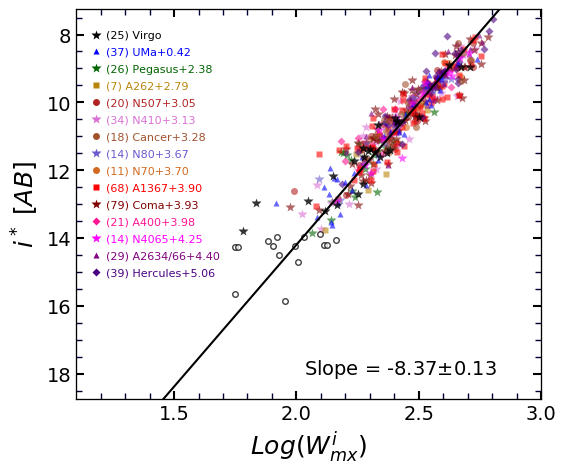

In [6]:
dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}
cmap = get_cmap(21)
fig, ax, x_ax, y_ax = makeFig(band=band, xLim = (1.1,2.9), yLim = (18.75,7.25), MAGabs=False, getTwinAX=True)

key0 = 'NEST_100002'
myCluster = Clusters[key0]
zp_virgo = myCluster['zp']
I_mag = myCluster['mag']
logWimx = myCluster['logWimx']
pgc_ = myCluster['pgc']


symcol = {}
symcol['NEST_100002']=['Virgo', '*', 'black']
symcol['NEST_100008']=['UMa', '^', 'blue']
symcol['NEST_200015']=['Fornax', 's', 'green']
symcol['NEST_100003']=['Centaurus', 'D', 'dodgerblue']
symcol['NEST_100014']=['Antlia', '.', 'olive']
symcol['NEST_200092']=['Pegasus', '*', 'darkgreen']
symcol['NEST_100006']=['Hydra', '^', 'm']
symcol['NEST_200003']=['A262', 's', 'darkgoldenrod']
symcol['NEST_200005']=['N410', '*', 'orchid']
symcol['NEST_200006']=['N507', '.', 'firebrick']
symcol['NEST_100030']=['Cancer', '.', 'sienna']
symcol['NEST_200045']=['N80', '*', 'slateblue']
symcol['NEST_200037']=['N70', '.', 'chocolate']
symcol['NEST_100005']=['A1367', 's', 'red']
symcol['NEST_100001']=['Coma', '*', 'maroon']
symcol['NEST_200012']=['A400', 'D', 'deeppink']
symcol['NEST_100018']=['N4065', '*', 'magenta']
symcol['NEST_200017']=['A539', 's', 'crimson']
symcol['NEST_200016']=['A2634/66', '^', 'purple']
symcol['NEST_100007']=['Hercules', 'D', 'indigo']



key_lst = []
d_lst = []
n_lst =[]
for i, key in enumerate(Clusters):
    
    if key!=key0:
        
        myCluster = Clusters[key]
        pgc = myCluster['pgc']
        zp_ = myCluster['zp']
        I_mag = myCluster['mag']-zp_+zp_virgo
        logWimx = myCluster['logWimx']
        
        key_lst.append(key)
        d_lst.append(zp_-zp_virgo)
        
        
        if symcol[key][1]=='*':
            size = 7
        elif symcol[key][1]=='D':
            size = 4    
        elif symcol[key][1]=='s':
            size = 4           
        elif symcol[key][1]=='^':
            size = 5   
        elif symcol[key][1]=='.':
            size = 10   

        indx = []
        indx_ = []    
        for i, id in enumerate(pgc):
            if not id in I_maglim:
                indx.append(i)
            else:
                indx_.append(i)             
            
        n_lst.append(len(logWimx[indx]))
        ax.plot(logWimx[indx], I_mag[indx], symcol[key][1], color=symcol[key][2], alpha=0.6, 
                markersize=size, markeredgecolor='none')
        ax.plot(logWimx[indx_], I_mag[indx_], 'ko', alpha=0.75, markersize=4, mfc='white')
        
        

myCluster = Clusters[key0]
I_mag = myCluster['mag']
logWimx = myCluster['logWimx']
pgc = myCluster['pgc']
indx = []
indx_ = []    
for i, id in enumerate(pgc):
    if not id in I_maglim:
        indx.append(i)
    else:
        indx_.append(i)  
key_lst.append(key0)
d_lst.append(0)
n_lst.append(len(logWimx[indx]))
ax.plot(logWimx[indx], I_mag[indx], symcol[key0][1], color=symcol[key0][2], alpha=0.8,
        markersize=7, markeredgecolor='none')
ax.plot(logWimx[indx_], I_mag[indx_], 'ko', alpha=0.75, markersize=4, mfc='white')
        


        

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()

ax.text(2.03,18, "Slope = "+"%.2f" % slope0+'$\pm$'+"%.2f" % slope_e0, fontsize=14, color='k')

ax.set_xticks(np.arange(1.5,3.5, step=0.5))
x_ax.set_xticks(np.arange(1.5,3.5, step=0.5))

x = np.linspace(-5,5,50)
y = slope*(x-2.5)+zp_virgo
ax.plot(x,y, 'k-')

indx  = np.argsort(d_lst)

p = 0 
for i in indx:
    key = key_lst[i]
    print d_lst[i], key_lst[i], symcol[key][0]
    
    if symcol[key][1]=='*':
        size = 7
    elif symcol[key][1]=='D':
        size = 4    
    elif symcol[key][1]=='s':
        size = 4           
    elif symcol[key][1]=='^':
        size = 5   
    elif symcol[key][1]=='.':
        size = 10       
    
    label = '(%d) '%n_lst[i]+symcol[key][0]+'+'+'%.2f'%d_lst[i]
    if key==key0: label = '(%d) '%n_lst[i]+symcol[key][0]
    ax.plot([1.18],[8+0.5*p], symcol[key][1], color=symcol[key][2], alpha=1, 
                markersize=size, markeredgecolor='none')
    ax.text(1.22,8.1+0.5*p, label, fontsize=8, color=symcol[key][2])
    p+=1


In [7]:
def rmsMaker(logWimx, mag, logWimx_e, slope, zp, pgc=None):
    

#     indx, = np.where(mag<-18)    
#     logWimx = logWimx[indx]
#     mag = mag[indx]
#     logWimx_e = logWimx_e[indx]
#     print pgc[indx]
    N = len(mag)
    indx = np.arange(N)

    
    mag_fit = slope*(logWimx-2.5)+zp
#     rms = np.sqrt(np.mean((mag-mag_fit)**2))
    delta = mag-mag_fit

    Y_fit2 = delta
    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]


    N = len(Y_fit2)
    rms =  np.sqrt(np.sum(Y_fit2**2)/(N-1))    
    
    
    
    
    logWimx_f = (mag-zp)/slope+2.5
    RMS = np.abs(slope*(np.sqrt(np.sum((logWimx-logWimx_f)**2/logWimx_e**2)/np.sum(1./logWimx_e**2))))
    
    return rms, RMS

-8.366864279175843 -20.84750325942105
i 40 -20.85 0.09 0.56 0.59


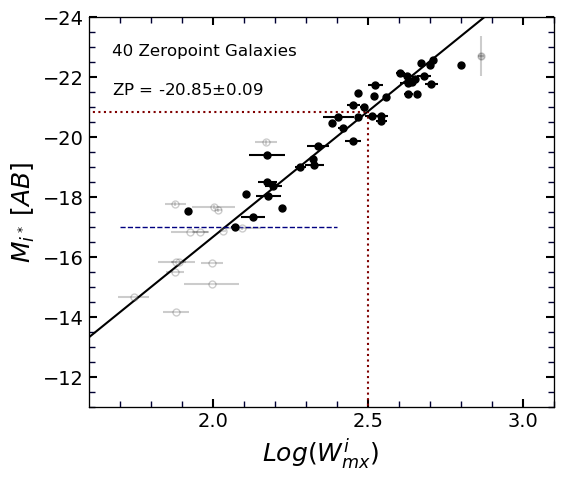

In [8]:
fig, ax = makeFig(band=band, xLim = (1.6,3.1), yLim = (-11,-24), MAGabs=True)



# plotCluster(ax, zp_calibs, offset=0, plotErrors=False, alpha=0.7, 
#             markersize=0, plotFit=True, pgcFaint=I_maglim)

m0 = zp_calibs['slope']
b0 = zp_calibs['zp']
dm0 = zp_calibs['slope_e']
db0 = zp_calibs['zp_e']
mag_ = zp_calibs['MAG']
logWimx_ = zp_calibs['logWimx']
mag_e = zp_calibs['mag_e']
logWimx_e = zp_calibs['logWimx_e']
pgc = zp_calibs['pgc']


mag_w = zp_calibs['MAG_w']
logWimx_w = zp_calibs['logWimx_w']
mag_e_w = zp_calibs['mag_e_w']
logWimx_e_w = zp_calibs['logWimx_e_w']
pgc_w = zp_calibs['pgc_w']

dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}


indx = []
indx_ = []    
for i, id in enumerate(pgc):
    if not id in calib_maglim:
        indx.append(i)
    else:
        indx_.append(i)  




ax.errorbar(logWimx_[indx], mag_[indx], fmt='o',  
                        markersize=5,
                    xerr=logWimx_e[indx], color = 'k')



indxS = []
indx_S = []    
for i, id in enumerate(pgc_w):
    if not id in [42407]:
        indxS.append(i)
    else:
        indx_S.append(i)

ax.errorbar(logWimx_w[indxS], mag_w[indxS], fmt='o',  
                        markersize=5,
                    xerr=logWimx_e_w[indxS], yerr=mag_e_w[indxS], color = 'k', alpha=0.2, markerfacecolor='white')

ax.errorbar(logWimx_w[indx_S], mag_w[indx_S], fmt='o',  
                        markersize=5,
                    xerr=logWimx_e_w[indx_S], yerr=mag_e_w[indx_S], color = 'k', alpha=0.2)





if len(indx_)>0:
            ax.errorbar(logWimx_[indx_], mag_[indx_], fmt='o',  
                    xerr=logWimx_e[indx_], color='k', markersize=5, alpha=0.2, markerfacecolor='white')


x = np.linspace(-5,5,50)
y = slope*(x-2.5)+zp
ax.plot(x,y, 'k-')  

x0 = 2.5
y0 = 100
x1 = 2.5
y1 = slope*(x1-2.5)+zp
ax.plot([x0,x1],[y0,y1], ':', color='maroon') 

x2 = -5
y2 = y1
x3 = x1
y3 = y1
ax.plot([x2,x3],[y2,y3], ':', color='maroon')   



print m0, b0
N = len(logWimx_[indx])


Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.95*Xlm[0]+0.05*Xlm[1]
y0 = 0.1*Ylm[0]+0.90*Ylm[1]
ax.text(x0,y0, "%d" % N+' Zeropoint Galaxies', fontsize=12, color='k')
y0 = 0.2*Ylm[0]+0.80*Ylm[1]
ax.text(x0,y0, "ZP = "+"%.2f" % b0+'$\pm$'+"%.2f" % db0, fontsize=12, color='k')

rms,RMS = rmsMaker(logWimx_[indx], mag_[indx], logWimx_e[indx], slope, zp, pgc=pgc[indx])
print band, N, '%.2f'%b0, '%.2f'%db0[0], '%.2f'%rms, '%.2f'%RMS


if band=='i':
    x = np.linspace(1.7,2.4,20)
    ax.plot(x,-17*x/x,'--', lw=1, color='navy')
#     ax.text(2.45,-16.8, r'$M_{i^*}=-17$'+' mag', fontsize=11, color='navy')

if band=='w1':
    x = np.linspace(1.6,2.4,20)
    s = (1.177393433782687, 0.009308586408508734, 0.0091001076648074)
    z = (-0.47163516612878476, 0.0016568251714184634, 0.0016403255312730791)
    ax.plot(x,-17-(s[0]*(x-2.5)+z[0]),'r--', lw=1)